In [1]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import json
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from torchvision.models import resnet50, ResNet50_Weights

c:\Users\Penguin\anaconda3\envs\evasion\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Patch

torch.Size([1, 3, 224, 224])
ballplayer


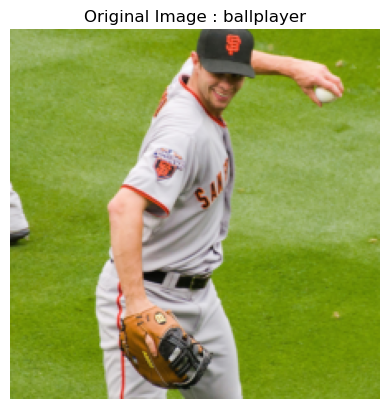

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1).to(device)
model.eval()

class_idx = json.load(open("../data/imagenet_class_index.json"))
idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]

input_image= "../data/person.jpg"

image = Image.open(input_image).convert("RGB")

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

image_tensor = preprocess(image).unsqueeze(0).to(device)

print(image_tensor.shape)

output = model(image_tensor)

_, predict = torch.max(output,1)

labels = idx2label[predict.item()]

print(labels)

original_image = image_tensor.squeeze(0).permute(1,2,0).detach().cpu().numpy()
original_image = np.clip(original_image, 0, 1)

plt.imshow(original_image)
plt.axis("off")
plt.title(f"Original Image : {labels}")
plt.show()

In [6]:
def random_transformation(image, patch, patch_size, max_rotation=30):
    
    image_size = image.shape[-2:]
    
    patch_location = (random.randint(0, image_size[0]-patch_size[0]),
                      random.randint(0, image_size[1]-patch_size[1]))

    # 랜덤 회전
    angle = random.uniform(-max_rotation, max_rotation)
    patch_rotated = TF.rotate(patch, angle)

    # 이미지에 패치 적용
    patched_image = image.clone()
    patched_image[:, :, patch_location[0]:patch_location[0]+patch_size[0], patch_location[1]:patch_location[1]+patch_size[1]] = patch_rotated
    
    return patched_image

def patch_generate(input, iterations, learning_rate, patch_size, patch_location, target_class):

    patch = torch.rand(1,3,patch_size[0],patch_size[1], requires_grad=True)
    optimizer = optim.Adam([patch], learning_rate)

    for i in range(iterations):
        
        patched_image = random_transformation(input, patch, patch_size)

        output = model(patched_image)
        loss = -output[0, target_class]

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return patched_image

iterations = 1000
learning_rate = 0.01
patch_size = (50, 50)
patch_location = (20, 20)
target_class = 1

patched_image = patch_generate(image_tensor, iterations, learning_rate, patch_size, patch_location, target_class)

In [7]:
print(patched_image.shape)

adversarial_output = model(patched_image)
_, adversarial_labels = torch.max(adversarial_output, 1)
adversarial_labels = idx2label[adversarial_labels.item()]

print(adversarial_labels)

torch.Size([1, 3, 224, 224])
goldfish


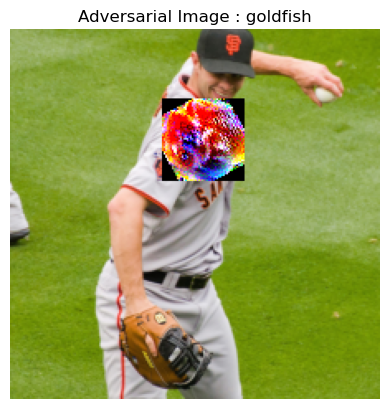

In [8]:
adversarial_image = patched_image.squeeze(0).permute(1,2,0).detach().cpu().numpy()
adversarial_image = np.clip(adversarial_image, 0, 1)

plt.imshow(adversarial_image)
plt.axis("off")
plt.title(f"Adversarial Image : {adversarial_labels}")
plt.show()